# Information Retrieval Project
**Multilingual and Cross‑Lingual Retrieval with BM25, LaBSE, Hybrid Fusion and Reranking**

**Authors:** Delia Mennitti (19610), Letizia Meroi (19041), Sara Napolitano (24656)

# Introduction

Modern information retrieval must support multilingual and cross‑lingual search, where user queries and target documents may be written in different languages. Traditional **sparse retrieval** methods such as BM25 rely on lexical overlap and therefore struggle with paraphrases, synonyms and, most importantly, language mismatch.

Recent multilingual language models enable **dense retrieval**, which maps texts into a shared embedding space and can capture semantic similarity across languages. 

This project evaluates how much dense retrieval improves multilingual IR and whether combining sparse and dense signals yields the best overall performance.

## Project Objectives
We systematically compare sparse, dense and hybrid retrieval across multiple languages and splits. Specifically, we:
1. **Establish a strong sparse baseline** using **BM25**.
2. **Implement dense retrieval** with **LaBSE**, a state‑of‑the‑art multilingual sentence embedding model.
3. **Develop a hybrid approach** by fusing BM25 and LaBSE scores with language‑specific tuning.
4. **Implement a neural reranking stage** using the hybrid approach to improve ranking quality.
5. **Evaluate performance** on 5 languages in monolingual and cross‑lingual settings using Recall@10 and MRR@10.
6. **Analyze language‑specific behavior** to understand which methods work best and why.

## Research Questions
- **RQ1:** How does dense semantic retrieval (LaBSE) compare to sparse lexical retrieval (BM25) for monolingual IR?
- **RQ2:** What gains does dense retrieval provide in cross‑lingual settings where query and document are in different languages?
- **RQ3:** Can a hybrid approach outperform either method alone, and how should the BM25/LaBSE balance vary by language?
- **RQ4**: How much does neural reranking improve the effectiveness of the dense or hybrid across languages, and is the improvement consistent in monolingual vs. cross-lingual retrieval?

## Technical Approach
The project implements an end‑to‑end retrieval pipeline:
- **Data processing** from SWIM‑IR JSONL files
- **BM25 retrieval** with language‑specific tokenization
- **Dense retrieval** using LaBSE embeddings and cosine similarity
- **Hybrid fusion** with validation‑based α tuning
- **Cross‑encoder reranking** for high‑precision top‑K results
- **Reproducible evaluation** with cached artifacts and frozen result files

# Dataset and Task Description

We use the **SWIM‑IR dataset**, described in *“Leveraging LLMs for Synthesizing Training Data Across Many Languages in Multilingual Dense Retrieval”* (Thakur et al.). The task focuses on **cross‑lingual IR**: given a query in another language, retrieve the relevant passage **in English**. Each query has exactly one relevant passage, enabling automatic evaluation.

The dataset contains three main splits:
- **monolingual**: query and document are in the same language
- **cross_lingual**: query in a non‑English language, document in English (17 languages)
- **cross_lingual_ext**: extended cross‑lingual split focusing on Indic languages (16 languages)

This setup allows direct comparison of monolingual versus cross‑lingual retrieval performance.

### Language Selection
We select 5 representative languages spanning multiple language families and scripts:
- **German (de)** — Germanic
- **French (fr)** — Romance
- **Spanish (es)** — Romance
- **English (en)** — Germanic
- **Chinese (zh)** — Sino‑Tibetan (cross‑lingual only)

This subset provides diversity while keeping experiments feasible on available hardware.

In [1]:
# Imports for data handling, retrieval, and visualization
import os
import json
import gzip
import random
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast
from rank_bm25 import BM25Okapi
import jieba
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from IPython.display import Markdown, display
import copy
import time

/opt/anaconda3/envs/ir_env/lib/python3.10/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Base path to the SWIM-IR dataset
BASE_DATA_DIR = "data/swim_ir_v1/swim_ir_v1"

# Exploratory Data Analysis

Before building retrieval models, we examine the dataset’s structure and scale to motivate design choices and interpret results.

The following blocks:
- **Compute corpus sizes** per split and language and visualize the distribution.
- **List document counts per language** to understand coverage.
- **Estimate text length statistics** (documents, queries, titles) on a small sample.

These checks inform parameters (such as `MAX_ITEMS`, `CANDIDATE_N` and reranking) limits and help explain performance differences across languages.

SWIM-IR DATASET OVERVIEW

Splits: 3 (monolingual, cross_lingual_ext, cross_lingual)
Total languages: 33
Total query-document pairs: 18,699,888

By split:
  monolingual: 10 languages, 3,167,012 pairs
  cross_lingual_ext: 16 languages, 92,954 pairs
  cross_lingual: 17 languages, 15,439,922 pairs


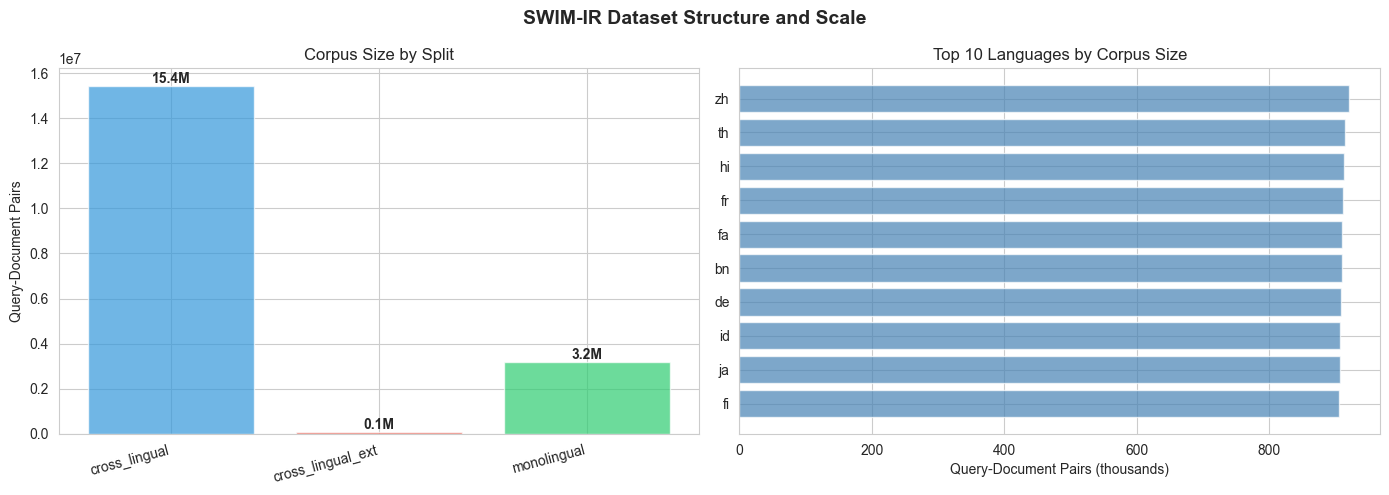

In [3]:
# Dataset overview and corpus statistics
sns.set_style("whitegrid")

# Get structure and count corpus sizes
dataset_structure = {}
corpus_sizes = []

for split in os.listdir(BASE_DATA_DIR):
    split_path = os.path.join(BASE_DATA_DIR, split)
    if os.path.isdir(split_path) and not split.startswith('.'):
        languages = [d for d in os.listdir(split_path) 
                    if os.path.isdir(os.path.join(split_path, d)) and not d.startswith('.')]
        dataset_structure[split] = sorted(languages)
        
        # Count items per language
        for lang in languages:
            lang_path = os.path.join(split_path, lang, "train.jsonl")
            if os.path.isfile(lang_path):
                with open(lang_path, 'r', encoding='utf-8') as f:
                    count = sum(1 for _ in f)
                corpus_sizes.append({'split': split, 'language': lang, 'num_items': count})

df_sizes = pd.DataFrame(corpus_sizes)

print("="*70)
print("SWIM-IR DATASET OVERVIEW")
print("="*70)
print(f"\nSplits: {len(dataset_structure)} ({', '.join(dataset_structure.keys())})")
print(f"Total languages: {len(set([l for ls in dataset_structure.values() for l in ls]))}")
print(f"Total query-document pairs: {df_sizes['num_items'].sum():,}")
print(f"\nBy split:")
for split in dataset_structure:
    split_total = df_sizes[df_sizes['split']==split]['num_items'].sum()
    print(f"  {split}: {len(dataset_structure[split])} languages, {split_total:,} pairs")

# Compact visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('SWIM-IR Dataset Structure and Scale', fontsize=14, fontweight='bold')

# Split distribution
ax1 = axes[0]
split_totals = df_sizes.groupby('split')['num_items'].sum()
ax1.bar(range(len(split_totals)), split_totals.values, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
ax1.set_xticks(range(len(split_totals)))
ax1.set_xticklabels(split_totals.index, rotation=15, ha='right')
ax1.set_ylabel('Query-Document Pairs')
ax1.set_title('Corpus Size by Split')
for i, v in enumerate(split_totals.values):
    ax1.text(i, v, f'{v/1e6:.1f}M', ha='center', va='bottom', fontweight='bold')

# Top languages
ax2 = axes[1]
top_10 = df_sizes.nlargest(10, 'num_items')
ax2.barh(range(len(top_10)), top_10['num_items']/1000, color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels([f"{r['language']}" for _, r in top_10.iterrows()])
ax2.set_xlabel('Query-Document Pairs (thousands)')
ax2.set_title('Top 10 Languages by Corpus Size')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

In [4]:
# Summarize total document counts per language
print("="*70)
print("DOCUMENT COUNT BY LANGUAGE")
print("="*70)

lang_counts = df_sizes.groupby('language')['num_items'].sum().sort_values(ascending=False)

print(f"\nTotal unique languages: {len(lang_counts)}")
print(f"Total documents across all languages: {lang_counts.sum():,}\n")

print("Documents per language:")
print("-" * 40)
for lang, count in lang_counts.items():
    print(f"  {lang:>5s}: {count:>8,} documents")
print("="*70)

DOCUMENT COUNT BY LANGUAGE

Total unique languages: 33
Total documents across all languages: 18,699,888

Documents per language:
----------------------------------------
     es: 1,398,307 documents
     fr: 1,359,439 documents
     de: 1,356,063 documents
     fi: 1,260,154 documents
     id: 1,216,891 documents
     ar: 1,179,014 documents
     hi: 1,145,955 documents
     bn: 1,016,564 documents
     zh:  921,701 documents
     th:  914,610 documents
     fa:  910,295 documents
     yo:  907,259 documents
     ja:  906,862 documents
     ko:  905,669 documents
     sw:  905,242 documents
     ru:  904,933 documents
     te:  902,190 documents
     en:  501,538 documents
     mr:    5,977 documents
     ta:    5,930 documents
     ml:    5,907 documents
     as:    5,899 documents
     gu:    5,870 documents
     pa:    5,840 documents
     or:    5,837 documents
     ur:    5,816 documents
     sa:    5,779 documents
    mai:    5,768 documents
    bho:    5,763 documents
     kn:  

TEXT LENGTH CHARACTERISTICS

Documents: ~97 words
Queries: ~8 words
Titles: ~2 words

Documents are ~11.9x longer than queries


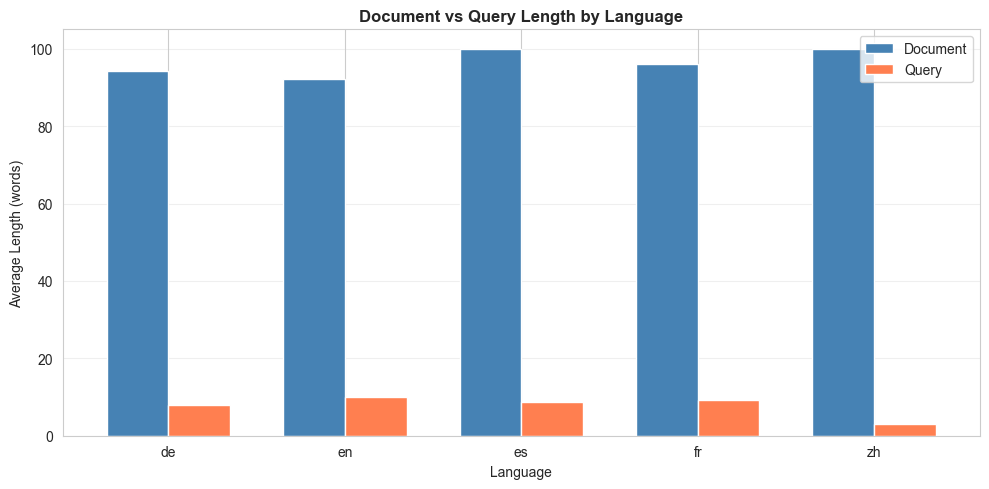

In [5]:
# Text length analysis
SAMPLE_SIZE = 500
SELECTED_LANGUAGES_EDA = ['de', 'fr', 'es', 'en', 'zh']
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

text_stats = []
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    if not os.path.exists(split_path):
        continue
        
    for lang in SELECTED_LANGUAGES_EDA:
        lang_path = os.path.join(split_path, lang, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        doc_lengths, query_lengths, title_lengths = [], [], []
        with open(lang_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i >= SAMPLE_SIZE:
                    break
                try:
                    item = ast.literal_eval(line.strip())
                    doc_lengths.append(len(item.get('text', '').split()))
                    query_lengths.append(len(item.get('query', '').split()))
                    title_lengths.append(len(item.get('title', '').split()))
                except:
                    continue
        
        if doc_lengths:
            text_stats.append({
                'split': split, 'language': lang,
                'avg_doc': np.mean(doc_lengths),
                'avg_query': np.mean(query_lengths),
                'avg_title': np.mean(title_lengths)
            })

df_text = pd.DataFrame(text_stats)

if len(df_text) > 0:
    print("="*70)
    print("TEXT LENGTH CHARACTERISTICS")
    print("="*70)
    print(f"\nDocuments: ~{df_text['avg_doc'].mean():.0f} words")
    print(f"Queries: ~{df_text['avg_query'].mean():.0f} words")
    print(f"Titles: ~{df_text['avg_title'].mean():.0f} words")
    print(f"\nDocuments are ~{df_text['avg_doc'].mean() / df_text['avg_query'].mean():.1f}x longer than queries")
    
    # Single compact visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comparison = df_text.groupby('language')[['avg_doc', 'avg_query']].mean()
    comparison.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], width=0.7)
    ax.set_ylabel('Average Length (words)')
    ax.set_xlabel('Language')
    ax.set_title('Document vs Query Length by Language', fontweight='bold')
    ax.legend(['Document', 'Query'])
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## EDA Summary of Findings

- **Scale and coverage:** 18,699,888 query–document pairs across **33 languages** and **3 splits**.
- **Split imbalance:** cross_lingual dominates with **15,439,922** pairs vs **3,167,012** monolingual and **92,954** cross_lingual_ext.
- **Language skew (long tail):** top languages are around **1.3–1.4M** pairs each (e.g., es 1,398,307; fr 1,359,439; de 1,356,063), while the smallest languages in the extended split are ~**5.6k** pairs (e.g., mni 5,604).
- **English is mid‑size:** en has **501,538** pairs—far below the largest languages but far above the long tail.
- **Document length >> query length (sampled):** documents are several times longer than queries across languages, motivating robust matching and hybrid/semantic methods.
- **Cross‑lingual challenge is structural:** queries are in a non‑English language while documents are in English, so lexical overlap is limited—supporting the need for dense retrieval and fusion.

These observations guide our experimental choices (e.g., limiting `MAX_ITEMS` for feasibility, using `CANDIDATE_N` for reranking and evaluating per language).

# Methodology

## Evaluation Metrics
We report two standard ranking metrics at $K=10$:
- **Recall@10** — fraction of queries whose relevant document appears in the top‑10.
  $$\text{Recall@10} = \frac{\text{Nr. queries with relevant doc in top‑10}}{|Q|}$$
- **MRR@10** — mean reciprocal rank of the first relevant document, capped at 10.
  $$\text{MRR@10} = \frac{1}{|Q|}\sum_{q=1}^{|Q|} \frac{1}{\text{rank}_q}$$
Both range from 0 to 1; higher is better.

## Retrieval Methods
We compare three approaches:
1. **BM25** (sparse lexical baseline).
2. **LaBSE** (dense multilingual embeddings).
3. **Hybrid fusion** (weighted combination of BM25 and LaBSE, with α tuned on a validation split).
4. **Neural reranking** (a multilingual cross-encoder applied to the top-K_rerank candidates returned by the tuned hybrid retriever)

For each method, we retrieve top‑10 results per query and evaluate against the single ground‑truth relevant passage. Caching is used throughout to ensure reproducible runs and fast re‑evaluation.

# 1. Baseline: BM25 (Sparse Lexical Retrieval)

BM25 is a strong lexical baseline widely used in IR. It scores documents based on term frequency and inverse document frequency, relying on exact term overlap.

**Key properties:**
- Lexical matching (no semantic understanding)
- Language‑specific tokenization (jieba for Chinese)
- Fast and scalable for large corpora

**What the following code does:**
- Loads SWIM‑IR JSONL files and builds document/query maps
- Tokenizes text per language and computes BM25 scores
- Retrieves top‑$K$ documents per query
- Caches top‑N results to disk for reproducibility and faster reruns

This establishes a clear baseline against which dense and hybrid methods can be measured.

In [6]:
def encode_texts(texts, batch_size=1):
    """Encode texts to embeddings (conservative by default)."""
    if not globals().get('RUN_DENSE', False):
        raise RuntimeError('Dense encoding was disabled (RUN_DENSE=False)')
    
    if not texts:
        raise ValueError('No texts provided for encoding')
    
    print(f"  Encoding {len(texts)} texts with batch_size={batch_size}...")
    try:
        embeddings = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True  # important for cosine similarity
        )
    except MemoryError as me:
        print(f'[ERROR] MemoryError during encoding: {me}')
        gc.collect()
        raise
    gc.collect()
    return embeddings

In [7]:
# Global cache for scores
SCORE_CACHE = {}  # key: (split, lang) -> dict with bm25_scores, dense_scores, doc_ids, query_ids, qrels

# Run BM25 for each language folder under each split (cross_lingual, monolingual, etc.)
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

# Fixed set of languages to process (Italian not available in dataset)
SELECTED_LANGUAGES = ['de', 'fr', 'es', 'en', 'zh']  # German, French, Spanish, English, Chinese

# Reproducibility + logging control
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
VERBOSE = False
PRINT_EVERY = 50

MAX_ITEMS = 10000
K = 10  # top-K retrieval
CANDIDATE_N = 500  # candidates from BM25 and Dense (>= K)

# Robust JSONL loader
def load_jsonl_robust(path, max_items=MAX_ITEMS):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_items and i >= max_items:
                break
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                obj = ast.literal_eval(line)
            data.append(obj)
    return data

# Tokenizer
def tokenize(text, lang_code):
    if lang_code == "zh":
        return list(jieba.cut(text))
    else:
        return text.lower().split()

# Evaluation
def evaluate(retrieved, qrels, K=10):
    recalls = []
    rr_list = []
    for qid, top_docs in retrieved.items():
        relevant_doc = qrels[qid]
        recalls.append(1.0 if relevant_doc in top_docs[:K] else 0.0)
        try:
            rank = top_docs.index(relevant_doc) + 1
            rr_list.append(1.0 / rank)
        except ValueError:
            rr_list.append(0.0)
    return np.mean(recalls), np.mean(rr_list)

# Store results
results = []

print(f"Processing selected languages: {', '.join(SELECTED_LANGUAGES)}\n")

Processing selected languages: de, fr, es, en, zh



In [8]:
BM25_CACHE_DIR = "artifacts_cache_bm25"
os.makedirs(BM25_CACHE_DIR, exist_ok=True)

def bm25_cache_path(split, lang, max_items, k, topn):
    return os.path.join(BM25_CACHE_DIR, f"{split}__{lang}__max{max_items}__k{k}__topn{topn}.json")

def load_bm25_from_disk(split, lang, max_items=MAX_ITEMS, k=K, topn=None):
    if topn is None:
        topn = max(CANDIDATE_N, K)
    path = bm25_cache_path(split, lang, max_items, k, topn)
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def save_bm25_to_disk(split, lang, payload, max_items=MAX_ITEMS, k=K, topn=None):
    if topn is None:
        topn = payload.get("TOPN", max(CANDIDATE_N, K))
    path = bm25_cache_path(split, lang, max_items, k, topn)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f)



In [9]:
# put true only if you really need the QxD BM25 matrix
STORE_BM25_MATRIX = False  

In [10]:
# BM25 retrieval loop with caching and evaluation per split/language
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue
            
        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)

        TOPN = max(CANDIDATE_N, K)
        cached = load_bm25_from_disk(split, lang_code, MAX_ITEMS, K, TOPN)

        if cached is not None:
            print("BM25 cache hit – loading top-K from disk (skip BM25 computation)")

            # put in RAM cache for later hybrid/rerank
            SCORE_CACHE[(split, lang_code)] = SCORE_CACHE.get((split, lang_code), {})
            SCORE_CACHE[(split, lang_code)].update(cached)

            # Recompute metrics quickly from cached top-K
            recall, mrr = evaluate(cached["bm25_topk_docs"], cached["qrels"], K=K)
            results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": recall,
                "MRR@10": mrr,
                "method": "BM25"
            })
            continue

        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        # Tokenize corpus
        doc_ids = list(documents.keys())
        query_ids = list(queries.keys())

        tokenized_corpus = [tokenize(documents[doc_id]["text"], documents[doc_id]["lang"]) for doc_id in doc_ids]

        if len(tokenized_corpus) == 0:
            print("No documents found, skipping.")
            continue

        bm25 = BM25Okapi(tokenized_corpus)

        # Tokenize queries
        tokenized_queries = {qid: tokenize(q, documents[qid]["lang"]) for qid, q in queries.items()}

        # Optional: Build BM25 score matrix QxD
        Q = len(query_ids)
        D = len(doc_ids)
        bm25_scores_matrix = None
        if STORE_BM25_MATRIX:
            bm25_scores_matrix = np.zeros((Q, D), dtype=np.float32)

        # Retrieve top-K
        bm25_topk_docs = {}
        bm25_topk_scores = {}
        retrieved = {}
        TOPN = max(CANDIDATE_N, K)
        for i, qid in enumerate(query_ids):
            scores = np.asarray(bm25.get_scores(tokenized_queries[qid]), dtype=np.float32)
            if STORE_BM25_MATRIX:
                bm25_scores_matrix[i, :] = scores

            top_indices = scores.argsort()[-TOPN:][::-1]
            docs = [doc_ids[j] for j in top_indices]
            scs  = [float(scores[j]) for j in top_indices]

            retrieved[qid] = docs
            bm25_topk_docs[qid] = docs
            bm25_topk_scores[qid] = scs

        # Evaluate
        recall, mrr = evaluate(retrieved, qrels, K=K)
        results.append({"split": split, "language": lang_code, "Recall@10": recall, "MRR@10": mrr, "method": "BM25"})
        print(f"[OK] BM25 - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
        
        # Save to cache
        key = (split, lang_code)
        SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
        update_pack = {
            "bm25_topk_docs": bm25_topk_docs,
            "bm25_topk_scores": bm25_topk_scores,
            "doc_ids": doc_ids,
            "query_ids": query_ids,
            "qrels": qrels
        }
        if STORE_BM25_MATRIX:
            update_pack["bm25"] = bm25_scores_matrix

        SCORE_CACHE[key].update(update_pack)


        # Save only BM25 top-K to disk, matrix is large and remains in RAM
        payload = {
            "doc_ids": doc_ids,
            "query_ids": query_ids,
            "qrels": qrels,
            "bm25_topk_docs": bm25_topk_docs,
            "bm25_topk_scores": bm25_topk_scores,
            "TOPN": int(TOPN)
        }
        save_bm25_to_disk(split, lang_code, payload, MAX_ITEMS, K, TOPN)
        print("BM25 top-K cached to disk.")
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")


df_results


Processing monolingual/de
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/fr
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/es
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing monolingual/en
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/zh
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/de
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/fr
BM25 cache hit – loading top-K from disk (skip BM25 computation)

Processing cross_lingual/es
BM25 cache hit – loading top-K from disk (skip BM25 computation)

SUMMARY RESULTS

Total experiments: 8


,split,language,Recall@10,MRR@10,method
0,monolingual,de,0.7549,0.681533,BM25
1,monolingual,fr,0.4811,0.366876,BM25
2,monolingual,es,0.7005,0.574080,BM25
3,monolingual,en,0.8135,0.753508,BM25
4,cross_lingual,zh,0.3789,0.264577,BM25
5,cross_lingual,de,0.5065,0.371881,BM25
6,cross_lingual,fr,0.4036,0.272497,BM25
7,cross_lingual,es,0.2528,0.155201,BM25


# 2. Dense Retrieval Using Multilingual Embeddings

## Approach
Dense retrieval maps queries and documents into a shared semantic vector space, enabling similarity search even when there is little or no lexical overlap.

## Model Selection: LaBSE
We use **LaBSE** (Language‑agnostic BERT Sentence Embedding) because it provides strong cross‑lingual alignment and reliable zero‑shot performance across many languages.

## Implementation Details
We compute cosine similarity using **sklearn** rather than FAISS to ensure stability on the available hardware. The pipeline:
1. Encode all documents into 768‑dimensional vectors
2. Encode all queries into the same space
3. Compute cosine similarity (queries × documents)
4. Rank documents and retrieve top‑$K$
5. Cache results for reproducibility

This section allows a direct, fair comparison between dense retrieval and BM25 using identical evaluation metrics.

## Alternative Models Considered

We considered multiple multilingual embedding models:
- **mSBERT** — faster and smaller, but weaker cross‑lingual alignment
- **XLM‑R** — flexible but requires careful pooling and tuning
- **LaBSE** — strongest zero‑shot cross‑lingual performance and stable behavior

Given the goal of robust multilingual retrieval without additional fine‑tuning, **LaBSE** offered the best balance of accuracy and operational simplicity for this project.

In [11]:
# Dense retrieval: Using sklearn instead of FAISS (more stable)
RUN_DENSE = True  # set to False to skip dense retrieval

if RUN_DENSE:
    try:
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        model = SentenceTransformer("sentence-transformers/LaBSE")
        print('[OK] LaBSE model loaded')
        print('[OK] Using sklearn cosine_similarity (more stable than FAISS)')
    except Exception as e:
        print('Failed to load dense model:', e)
        RUN_DENSE = False
else:
    print('Dense retrieval disabled (RUN_DENSE=False)')

/opt/anaconda3/envs/ir_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[OK] LaBSE model loaded
[OK] Using sklearn cosine_similarity (more stable than FAISS)


In [12]:
# Dense cache utilities (atomic writes + corruption handling)
import os, json, tempfile

DENSE_CACHE_DIR = "artifacts_cache_dense"
os.makedirs(DENSE_CACHE_DIR, exist_ok=True)

def dense_cache_path(split, lang):
    return os.path.join(DENSE_CACHE_DIR, f"{split}__{lang}__max{MAX_ITEMS}__k{K}.json")

def load_dense_from_disk(split, lang):
    path = dense_cache_path(split, lang)
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except json.JSONDecodeError:
        # Corrupted file - rename to .bad and treat as cache miss
        bad = path + ".bad"
        try:
            os.replace(path, bad)
        except Exception:
            pass
        print(f"[WARN] Dense cache corrupt -> renamed to {bad}. Recompute...")
        return None

def save_dense_to_disk(split, lang, payload):
    os.makedirs(DENSE_CACHE_DIR, exist_ok=True)
    path = dense_cache_path(split, lang)

    # Atomic write, avoid partial files
    fd, tmp_path = tempfile.mkstemp(dir=DENSE_CACHE_DIR, suffix=".tmp")
    try:
        with os.fdopen(fd, "w", encoding="utf-8") as f:
            json.dump(payload, f)
            f.flush()
            os.fsync(f.fileno())
        os.replace(tmp_path, path)
    finally:
        if os.path.exists(tmp_path):
            try:
                os.remove(tmp_path)
            except Exception:
                pass

In [13]:
# Dense retrieval loop with caching and evaluation per split/language
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue

        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)

        # Check cache
        cached_dense = load_dense_from_disk(split, lang_code)
        if cached_dense is not None:
            print("Dense cache hit – loading precomputed top-N...")

            key = (split, lang_code)
            SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
            SCORE_CACHE[key].update(cached_dense)
            
            # Evaluate cached results
            recall, mrr = evaluate(cached_dense["dense_topk_docs"], cached_dense["qrels"], K=K)
            results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": recall,
                "MRR@10": mrr,
                "method": "LaBSE"
            })
            print(f"[OK] LaBSE - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
            continue

        print("Cache miss – computing scores...")

        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        
        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        
        doc_ids = list(documents.keys())
        query_ids = list(queries.keys())


        # Dense retrieval for this language using sklearn (no FAISS!)
        if globals().get('RUN_DENSE', False):
            try:
                # Encode documents
                doc_texts = [documents[doc_id]["text"] for doc_id in doc_ids]
                print(f"\n[DENSE] Encoding {len(doc_texts)} documents...")
                doc_embeddings = encode_texts(doc_texts)
                print(f"[OK] Document embeddings shape: {doc_embeddings.shape}")

                # Encode queries
                query_texts = [queries[qid] for qid in query_ids]
                print(f"\n[DENSE] Encoding {len(query_texts)} queries...")
                query_embeddings = encode_texts(query_texts)
                print(f"[OK] Query embeddings shape: {query_embeddings.shape}")

                # Use sklearn cosine_similarity instead of FAISS
                print(f"\n[DENSE] Computing cosine similarities...")
                # Compute similarity matrix: queries x documents
                similarities = cosine_similarity(query_embeddings, doc_embeddings)
                print(f"[OK] Similarity matrix shape: {similarities.shape}")
                
                # Get top-K for each query
                dense_topk_docs = {}
                dense_topk_scores = {}
                TOPN = max(CANDIDATE_N, K)
                for i, qid in enumerate(query_ids):
                    # Get similarities for this query
                    query_sims = similarities[i]
                    # Get top-K indices
                    top_indices = query_sims.argsort()[-TOPN:][::-1]

                    docs = [doc_ids[idx] for idx in top_indices]
                    scores = [float(query_sims[idx]) for idx in top_indices]

                    dense_topk_docs[qid] = docs
                    dense_topk_scores[qid] = scores
                    if VERBOSE and ((i + 1) % PRINT_EVERY == 0 or i == 0 or (i + 1) == len(query_ids)):
                        print(f"  Query {i+1}/{len(query_ids)}: done")

                # Evaluate
                recall, mrr = evaluate(dense_topk_docs, qrels, K=K)
                results.append({
                    "split": split,
                    "language": lang_code,
                    "Recall@10": recall,
                    "MRR@10": mrr,
                    "method": "LaBSE"
                })
                print(f"\n[OK] LaBSE - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
                
                # Save dense matrix to cache
                dense_payload = {
                    "doc_ids": doc_ids,
                    "query_ids": query_ids,
                    "qrels": qrels,
                    "dense_topk_docs": dense_topk_docs,
                    "dense_topk_scores": dense_topk_scores,
                    "TOPN": int(TOPN)
                }

                key = (split, lang_code)
                SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
                SCORE_CACHE[key].update(dense_payload)

                save_dense_to_disk(split, lang_code, dense_payload)
                print("Dense top-N cached to disk.")


                # Clean up
                del doc_embeddings, query_embeddings, similarities
                gc.collect()
                
            except Exception as e:
                print(f"\n[ERROR] Dense retrieval failed for {split}/{lang_code}: {e}")
                print("Continuing with next language...")
                import traceback
                traceback.print_exc()
                gc.collect()
        
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")

df_results


Processing monolingual/de
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.7738, MRR@10: 0.6480

Processing monolingual/fr
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.5731, MRR@10: 0.4422

Processing monolingual/es
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.7229, MRR@10: 0.5776

Processing monolingual/en
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.7569, MRR@10: 0.6419

Processing cross_lingual/zh
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.6242, MRR@10: 0.4703

Processing cross_lingual/de
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.5981, MRR@10: 0.4349

Processing cross_lingual/fr
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.5683, MRR@10: 0.4139

Processing cross_lingual/es
Dense cache hit – loading precomputed top-N...
[OK] LaBSE - Recall@10: 0.6001, MRR@10: 0.4407

SUMMARY RESULTS

Total 

,split,language,Recall@10,MRR@10,method
0,monolingual,de,0.7549,0.681533,BM25
1,monolingual,fr,0.4811,0.366876,BM25
2,monolingual,es,0.7005,0.574080,BM25
3,monolingual,en,0.8135,0.753508,BM25
4,cross_lingual,zh,0.3789,0.264577,BM25
5,cross_lingual,de,0.5065,0.371881,BM25
6,cross_lingual,fr,0.4036,0.272497,BM25
7,cross_lingual,es,0.2528,0.155201,BM25
8,monolingual,de,0.7738,0.647978,LaBSE
9,monolingual,fr,0.5731,0.442167,LaBSE


In [14]:
# copy and freeze results and use them later
results_frozen = copy.deepcopy(results)
df_results_frozen = df_results.copy(deep=True)

# save frozen results with timestamp
ts = time.strftime("%Y%m%d_%H%M%S")
df_results_frozen.to_pickle(f"df_results_frozen_{ts}.pkl")

print("Base results frozen and saved")

Base results frozen and saved


# Comparison between BM25 and LaBSE

DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)

[RESULTS] All Results:
        split language  Recall@10   MRR@10 method
  monolingual       de     0.7549 0.681533   BM25
  monolingual       fr     0.4811 0.366876   BM25
  monolingual       es     0.7005 0.574080   BM25
  monolingual       en     0.8135 0.753508   BM25
cross_lingual       zh     0.3789 0.264577   BM25
cross_lingual       de     0.5065 0.371881   BM25
cross_lingual       fr     0.4036 0.272497   BM25
cross_lingual       es     0.2528 0.155201   BM25
  monolingual       de     0.7738 0.647978  LaBSE
  monolingual       fr     0.5731 0.442167  LaBSE
  monolingual       es     0.7229 0.577638  LaBSE
  monolingual       en     0.7569 0.641910  LaBSE
cross_lingual       zh     0.6242 0.470342  LaBSE
cross_lingual       de     0.5981 0.434913  LaBSE
cross_lingual       fr     0.5683 0.413912  LaBSE
cross_lingual       es     0.6001 0.440664  LaBSE

AVERAGE PERFORMANCE BY METHOD
        Recall@10    MRR@10
method     

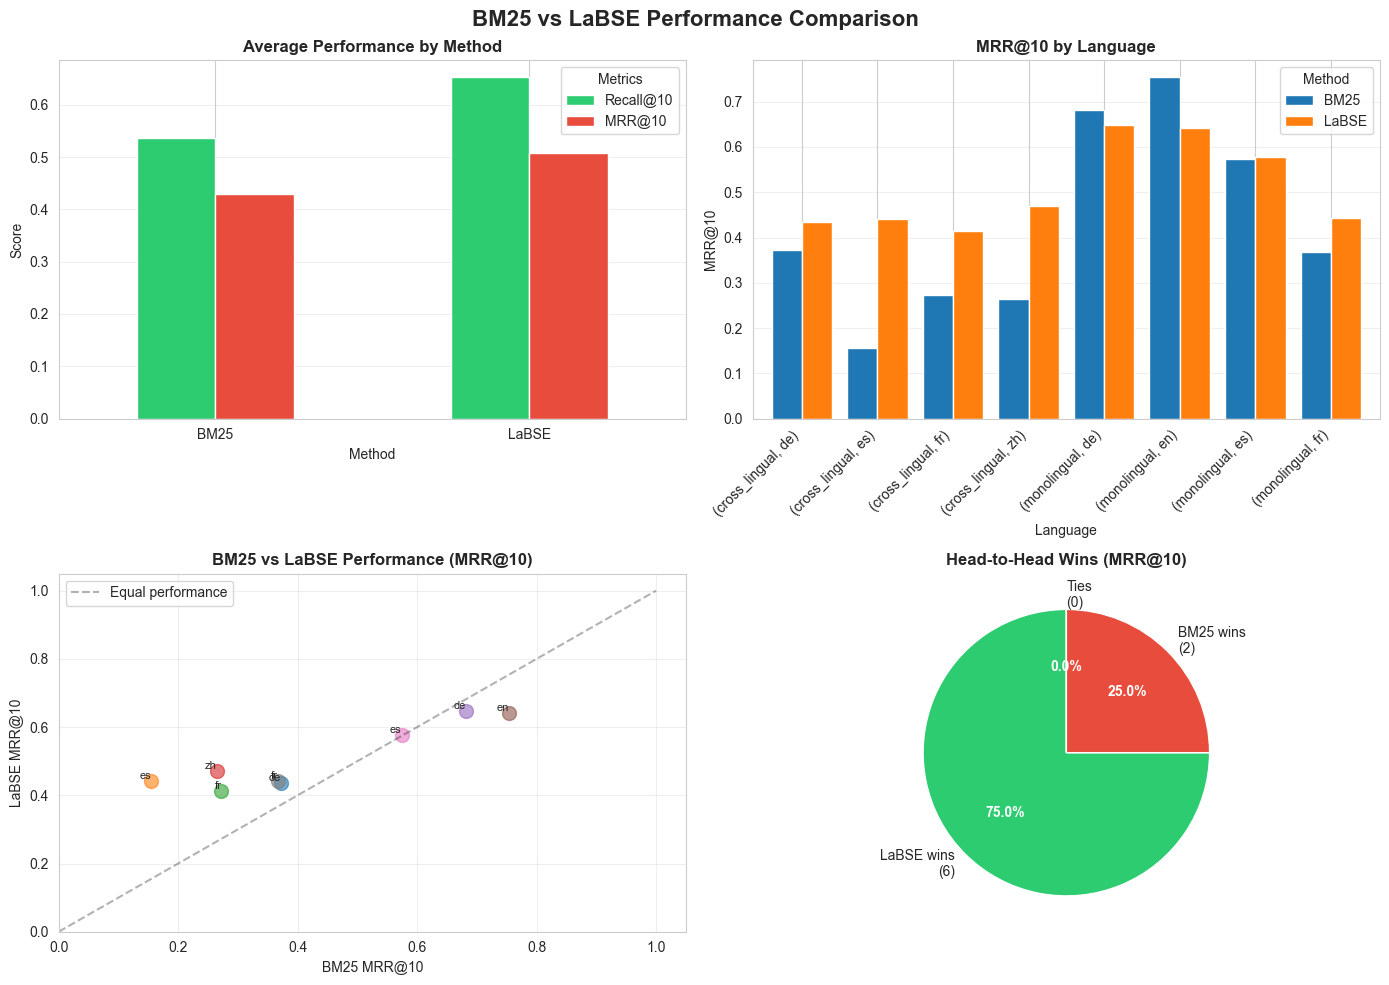

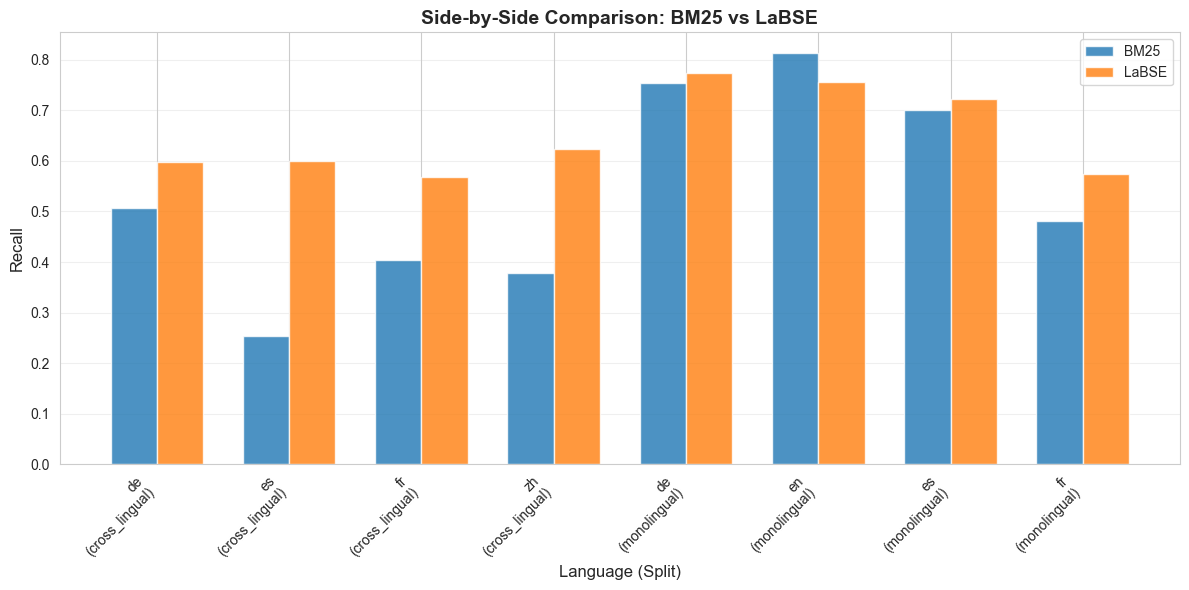

In [15]:
# Analyze and compare BM25 vs LaBSE (Dense BERT-based retrieval)

if 'df_results_frozen' in globals() and not df_results_frozen.empty:
    print("="*70)
    print("DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)")
    print("="*70)
    
    # Show all results
    print("\n[RESULTS] All Results:")
    print(df_results_frozen.to_string(index=False))
    
    # Compare by method
    print("\n" + "="*70)
    print("AVERAGE PERFORMANCE BY METHOD")
    print("="*70)
    method_avg = df_results_frozen.groupby('method')[['Recall@10', 'MRR@10']].mean()
    print(method_avg)
    
    # Compare by language
    print("\n" + "="*70)
    print("PERFORMANCE BY LANGUAGE")
    print("="*70)
    
    # Pivot table for easier comparison
    pivot_recall = df_results_frozen.pivot_table(
        values='Recall@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    pivot_mrr = df_results_frozen.pivot_table(
        values='MRR@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    print("\n[METRICS] Recall@10 by Language:")
    print(pivot_recall)
    
    print("\n[METRICS] MRR@10 by Language:")
    print(pivot_mrr)
    
    # Count wins
    if 'LaBSE' in df_results_frozen['method'].values and 'BM25' in df_results_frozen['method'].values:
        print("\n" + "="*70)
        print("HEAD-TO-HEAD COMPARISON")
        print("="*70)
        
        # Compare on Recall@10
        better_recall = (pivot_recall['LaBSE'] > pivot_recall['BM25']).sum()
        worse_recall = (pivot_recall['LaBSE'] < pivot_recall['BM25']).sum()
        tie_recall = (pivot_recall['LaBSE'] == pivot_recall['BM25']).sum()
        
        print(f"\n[COMPARISON] Recall@10 comparison:")
        print(f"  LaBSE wins: {better_recall}")
        print(f"  BM25 wins: {worse_recall}")
        print(f"  Ties: {tie_recall}")
        
        # Compare on MRR@10
        better_mrr = (pivot_mrr['LaBSE'] > pivot_mrr['BM25']).sum()
        worse_mrr = (pivot_mrr['LaBSE'] < pivot_mrr['BM25']).sum()
        tie_mrr = (pivot_mrr['LaBSE'] == pivot_mrr['BM25']).sum()
        
        print(f"\n[COMPARISON] MRR@10 comparison:")
        print(f"  LaBSE wins: {better_mrr}")
        print(f"  BM25 wins: {worse_mrr}")
        print(f"  Ties: {tie_mrr}")
        
        print("\n[INFO] LaBSE uses BERT-based dense embeddings (768-dim vectors)")
        print("[INFO] sklearn cosine_similarity for retrieval (no FAISS)")
        
        # Visualization plots
        print("\n" + "="*70)
        print("VISUALIZATIONS")
        print("="*70)
        
        # Set style
        sns.set_style("whitegrid")
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('BM25 vs LaBSE Performance Comparison', fontsize=16, fontweight='bold')
        
        # 1. Bar chart: Average metrics by method
        ax1 = axes[0, 0]
        method_avg.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
        ax1.set_title('Average Performance by Method', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Score')
        ax1.legend(title='Metrics')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Grouped bar chart: MRR@10 by language
        ax2 = axes[0, 1]
        pivot_mrr.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('MRR@10 by Language', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Language')
        ax2.set_ylabel('MRR@10')
        ax2.legend(title='Method')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Scatter plot: BM25 vs LaBSE (Recall)
        ax3 = axes[1, 0]
        for idx, row in pivot_mrr.iterrows():
            split, lang = idx if isinstance(idx, tuple) else (idx, idx)
            ax3.scatter(row['BM25'], row['LaBSE'], s=100, alpha=0.6)
            ax3.annotate(lang, (row['BM25'], row['LaBSE']), 
                        fontsize=8, ha='right', va='bottom')
        
        # Add diagonal line
        max_val = max(pivot_mrr.max().max(), 1.0)
        ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equal performance')
        ax3.set_xlim(0, max_val * 1.05)
        ax3.set_ylim(0, max_val * 1.05)
        ax3.set_xlabel('BM25 MRR@10')
        ax3.set_ylabel('LaBSE MRR@10')
        ax3.set_title('BM25 vs LaBSE Performance (MRR@10)', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Win/Loss pie chart
        ax4 = axes[1, 1]
        win_data = [better_mrr, worse_mrr, tie_mrr]
        labels = [f'LaBSE wins\n({better_mrr})', f'BM25 wins\n({worse_mrr})', f'Ties\n({tie_mrr})']
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        wedges, texts, autotexts = ax4.pie(win_data, labels=labels, colors=colors, 
                                             autopct='%1.1f%%', startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax4.set_title('Head-to-Head Wins (MRR@10)', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Language-wise comparison
        if len(pivot_recall) > 1:
            fig2, ax = plt.subplots(figsize=(12, 6))
            x = range(len(pivot_recall))
            width = 0.35
            
            ax.bar([i - width/2 for i in x], pivot_recall['BM25'], width, label='BM25', alpha=0.8)
            ax.bar([i + width/2 for i in x], pivot_recall['LaBSE'], width, label='LaBSE', alpha=0.8)
            
            ax.set_xlabel('Language (Split)', fontsize=12)
            ax.set_ylabel('Recall', fontsize=12)
            ax.set_title('Side-by-Side Comparison: BM25 vs LaBSE', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels([f"{idx[1]}\n({idx[0]})" for idx in pivot_recall.index], 
                              rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
else:
    print("[WARNING] No results available. Run the main loop (cell 11) first.")

## 3. Hybrid Approach (BM25 + Dense Retrieval)

Hybrid retrieval combines lexical precision from BM25 with semantic matching from dense embeddings.

**Method:**
- Compute BM25 and LaBSE scores for each query
- Normalize scores and combine them as: `score = α × BM25 + (1 − α) × LaBSE`
- Tune **α** on a validation split to avoid overfitting
- Evaluate on held‑out queries

Hybrid fusion often improves both Recall@10 and MRR@10 because it rewards documents that are strong both lexically and semantically.

The next code cell implements candidate‑based fusion, sweeps α, and reports per‑language performance.

In [16]:
# safe copy for hybrid experiments
results_hybrid = copy.deepcopy(results_frozen)

In [17]:
# Hybrid retrieval: tune alpha on a validation split and evaluate on held-out queries
CANDIDATE_N = 500          # candidate from BM25 e Dense (>= K)
alpha_grid = np.linspace(0.0, 1.0, 11)
seed = 42
val_ratio = 0.2

def to_score_dict(top_docs, top_scores):
    """Convert two lists (docs, scores) to {doc: score}."""
    return {d: float(s) for d, s in zip(top_docs, top_scores)}

def minmax_scores(score_map):
    """
    Min-max normalize a dict {doc: score} to [0,1] over its values.
    Returns dict {doc: norm_score}.
    """
    if not score_map:
        return {}
    vals = np.array(list(score_map.values()), dtype=np.float32)
    vmin, vmax = float(vals.min()), float(vals.max())
    if vmax == vmin:
        return {d: 0.0 for d in score_map}
    return {d: (float(s) - vmin) / (vmax - vmin) for d, s in score_map.items()}

def hybrid_topk_for_query(qid, alpha, pack, K=10, candN=100):
    """
    Candidate-based hybrid for a single query id.
    Combines BM25 and Dense scores on the union of their top candN docs.
    """
    bm_docs = pack["bm25_topk_docs"].get(qid, [])[:candN]
    bm_scs  = pack["bm25_topk_scores"].get(qid, [])[:candN]
    de_docs = pack["dense_topk_docs"].get(qid, [])[:candN]
    de_scs  = pack["dense_topk_scores"].get(qid, [])[:candN]

    bm_map = to_score_dict(bm_docs, bm_scs)
    de_map = to_score_dict(de_docs, de_scs)

    cands = set(bm_map) | set(de_map)
    if not cands:
        return []

    # Normalize within candidate set (missing docs get score 0.0)
    bm_norm = minmax_scores({d: bm_map.get(d, 0.0) for d in cands})
    de_norm = minmax_scores({d: de_map.get(d, 0.0) for d in cands})

    # Same formula as full hybrid, but only on candidates
    hybrid = [(d, alpha * bm_norm[d] + (1.0 - alpha) * de_norm[d]) for d in cands]
    hybrid.sort(key=lambda x: x[1], reverse=True)

    return [d for d, _ in hybrid[:K]]


#Rreset to avoid duplicates when re-running the cell
results_hybrid = copy.deepcopy(results_frozen) if "results_frozen" in globals() else []

# Drop any previous hybrid rows if present
results_hybrid = [r for r in results_hybrid if not str(r.get("method","")).startswith("Hybrid")]


alpha_curve_results = []

for split in CORPUS_SPLITS:
    for lang_code in SELECTED_LANGUAGES:
        key = (split, lang_code)
        if key not in SCORE_CACHE:
            continue

        pack = SCORE_CACHE[key]
        needed = ["qrels", "bm25_topk_docs", "bm25_topk_scores", "dense_topk_docs", "dense_topk_scores"]
        if any(k not in pack for k in needed):
            # Not all components present for hybrid
            continue

        qrels = pack["qrels"]
        query_ids = list(qrels.keys())  # qid==docid

        print(f"\n{'='*60}")
        print(f"Hybrid tuning for {split}/{lang_code}")
        print('='*60)

        # val/test split over query_ids
        rng = np.random.default_rng(seed)
        shuffled = query_ids.copy()
        rng.shuffle(shuffled)
        n_val = max(1, int(len(shuffled) * val_ratio))
        val_ids = shuffled[:n_val]
        test_ids = shuffled[n_val:] if n_val < len(shuffled) else shuffled[:]

        best_alpha = None
        best_val_mrr = -1.0
        best_val_recall = -1.0

        # ---- Tune alpha on VAL ----
        for alpha in alpha_grid:
            retrieved_val = {
                qid: hybrid_topk_for_query(qid, float(alpha), pack, K=K, candN=CANDIDATE_N)
                for qid in val_ids
            }

            recall_val, mrr_val = evaluate(retrieved_val, qrels, K=K)

            alpha_curve_results.append({
                "split": split,
                "language": lang_code,
                "alpha": float(alpha),
                "val_Recall@10": float(recall_val),
                "val_MRR@10": float(mrr_val),
                "val_ratio": float(val_ratio),
                "seed": int(seed),
                "candN": int(CANDIDATE_N),
            })

            # Tie-break: higher MRR, then higher recall, then smaller alpha
            if (mrr_val > best_val_mrr) or \
               (mrr_val == best_val_mrr and recall_val > best_val_recall) or \
               (mrr_val == best_val_mrr and recall_val == best_val_recall and (best_alpha is None or alpha < best_alpha)):
                best_val_mrr = mrr_val
                best_val_recall = recall_val
                best_alpha = float(alpha)

        print(f"[TUNE] Best alpha={best_alpha:.2f} on VAL | Recall@{K}={best_val_recall:.4f}, MRR@{K}={best_val_mrr:.4f}")

        # ---- Evaluate on TEST with best alpha ----
        retrieved_test = {
            qid: hybrid_topk_for_query(qid, best_alpha, pack, K=K, candN=CANDIDATE_N)
            for qid in test_ids
        }

        recall_test, mrr_test = evaluate(retrieved_test, qrels, K=K)

        results_hybrid.append({
            "split": split,
            "language": lang_code,
            "Recall@10": float(recall_test),
            "MRR@10": float(mrr_test),
            "method": "Hybrid(tuned)",
            "alpha": float(best_alpha),
            "val_Recall@10": float(best_val_recall),
            "val_MRR@10": float(best_val_mrr),
            "candN": int(CANDIDATE_N),
        })

        print(f"[OK] Hybrid TEST - alpha={best_alpha:.2f} - Recall@{K}: {recall_test:.4f}, MRR@{K}: {mrr_test:.4f}")
        gc.collect()

df_results_hybrid = pd.DataFrame(results_hybrid)
df_alpha_curve = pd.DataFrame(alpha_curve_results)

print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
print(f"\nTotal rows in df_results_hybrid: {len(df_results_hybrid)}")

# View only the important columns
df_results_hybrid[['split', 'language', 'method', 'Recall@10', 'MRR@10']]


Hybrid tuning for monolingual/de
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8735, MRR@10=0.7897
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.8691, MRR@10: 0.7850

Hybrid tuning for monolingual/fr
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.6570, MRR@10=0.5195
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.6500, MRR@10: 0.5254

Hybrid tuning for monolingual/es
[TUNE] Best alpha=0.30 on VAL | Recall@10=0.8275, MRR@10=0.7196
[OK] Hybrid TEST - alpha=0.30 - Recall@10: 0.8274, MRR@10: 0.7236

Hybrid tuning for monolingual/en
[TUNE] Best alpha=0.60 on VAL | Recall@10=0.8540, MRR@10=0.8030
[OK] Hybrid TEST - alpha=0.60 - Recall@10: 0.8511, MRR@10: 0.7979

Hybrid tuning for cross_lingual/de
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.7315, MRR@10=0.5720
[OK] Hybrid TEST - alpha=0.20 - Recall@10: 0.7126, MRR@10: 0.5405

Hybrid tuning for cross_lingual/fr
[TUNE] Best alpha=0.30 on VAL | Recall@10=0.6815, MRR@10=0.5256
[OK] Hybrid TEST - alpha=0.30 - Recall@10: 0.6890, MRR@10: 0.5305

Hybrid tuni

,split,language,method,Recall@10,MRR@10
0,monolingual,de,BM25,0.754900,0.681533
1,monolingual,fr,BM25,0.481100,0.366876
2,monolingual,es,BM25,0.700500,0.574080
3,monolingual,en,BM25,0.813500,0.753508
4,cross_lingual,zh,BM25,0.378900,0.264577
5,cross_lingual,de,BM25,0.506500,0.371881
6,cross_lingual,fr,BM25,0.403600,0.272497
7,cross_lingual,es,BM25,0.252800,0.155201
8,monolingual,de,LaBSE,0.773800,0.647978
9,monolingual,fr,LaBSE,0.573100,0.442167


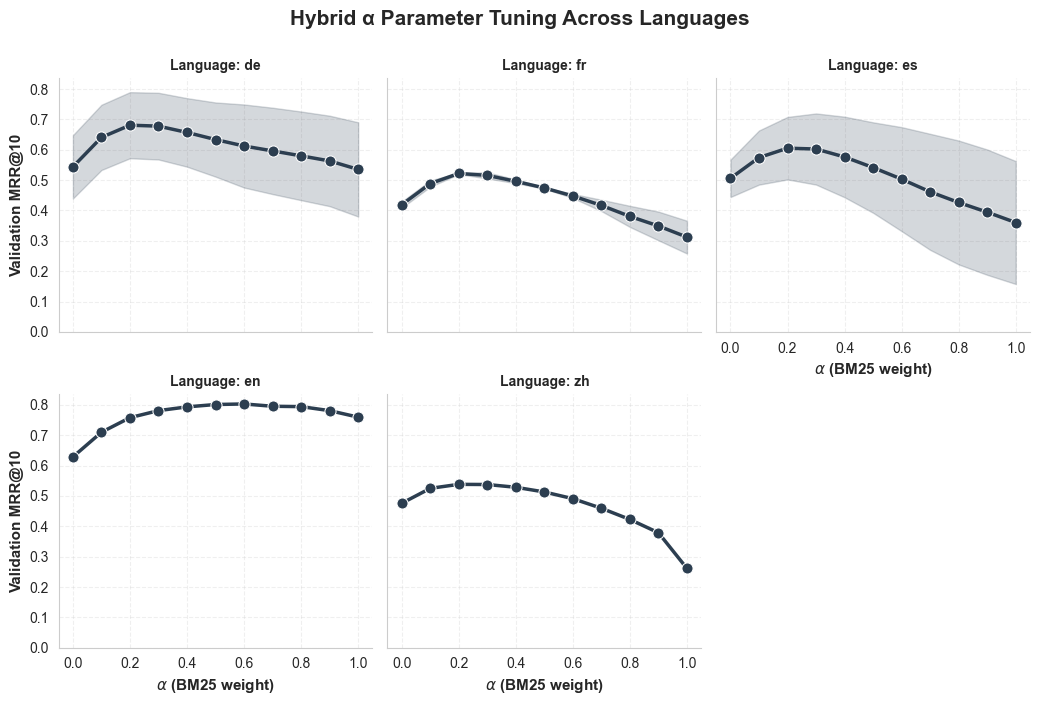

In [18]:
# Plot validation MRR vs alpha for hybrid tuning
sns.set_style("whitegrid")
sns.set_palette("husl")

g = sns.FacetGrid(
    df_alpha_curve,
    col="language",
    col_wrap=3,        
    height=3.5,
    sharey=True,
    sharex=True
)

g.map_dataframe(
    sns.lineplot,
    x="alpha",
    y="val_MRR@10",
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#2c3e50"
)

g.set_axis_labels(r"$\alpha$ (BM25 weight)", "Validation MRR@10", fontsize=11, fontweight='bold')
g.set_titles("Language: {col_name}", fontsize=12, fontweight='bold')
g.figure.suptitle(
    "Hybrid α Parameter Tuning Across Languages",
    fontsize=15,
    fontweight="bold",
    y=1.00
)

g.figure.subplots_adjust(wspace=0.3, hspace=0.4)

for ax in g.axes.flatten():
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


/var/folders/gl/sxzl68dx4b734nhcq_b6ltnc0000gn/T/ipykernel_16865/2379587065.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(violin_data, labels=method_order, patch_artist=True, widths=0.6)


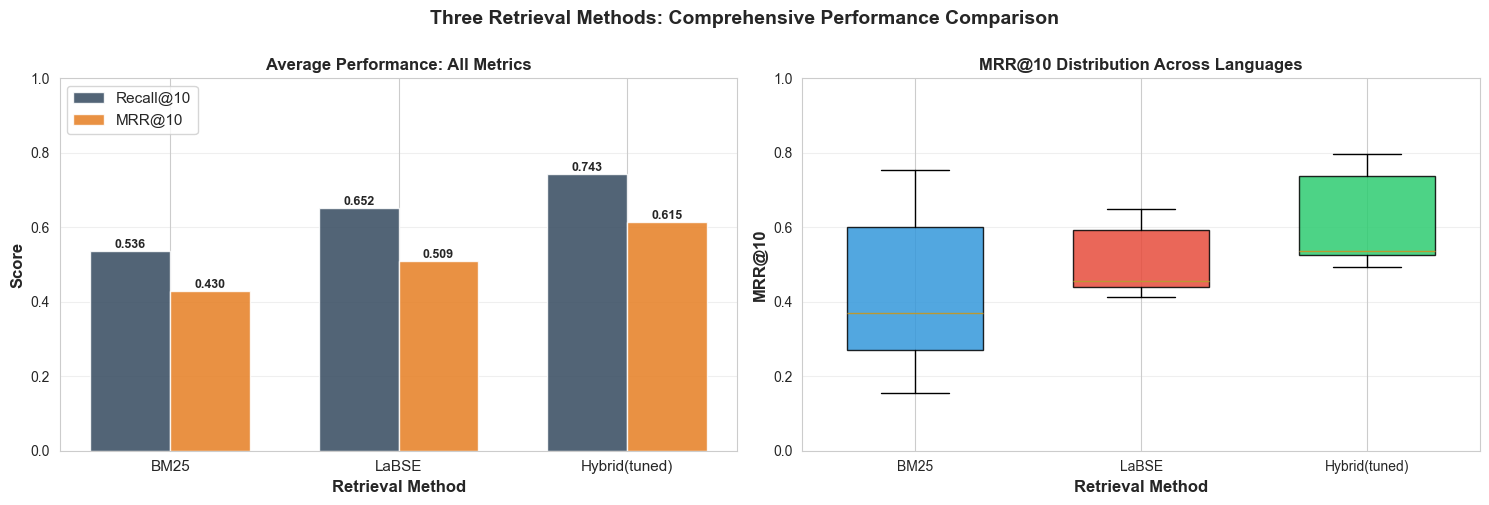

In [19]:
# Compare BM25, LaBSE, and Hybrid: overall metrics + distributions
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Three Retrieval Methods: Comprehensive Performance Comparison', fontsize=14, fontweight='bold', y=1.00)

# Left: Overall metrics comparison
ax1 = axes[0]
method_order = ["BM25", "LaBSE", "Hybrid(tuned)"]
colors_methods = ["#3498db", "#e74c3c", "#2ecc71"]

# Get average scores for each method
method_stats = df_results_hybrid.groupby('method')[['Recall@10', 'MRR@10']].mean().reindex(method_order)

x = np.arange(len(method_order))
width = 0.35

bars1 = ax1.bar(x - width/2, method_stats['Recall@10'], width, label='Recall@10', color='#34495e', alpha=0.85)
bars2 = ax1.bar(x + width/2, method_stats['MRR@10'], width, label='MRR@10', color='#e67e22', alpha=0.85)

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('Retrieval Method', fontsize=12, fontweight='bold')
ax1.set_title('Average Performance: All Metrics', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(method_order, fontsize=11)
ax1.legend(fontsize=11, loc='upper left')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Right: MRR@10 by method 
ax2 = axes[1]
violin_data = [df_results_hybrid[df_results_hybrid['method']==m]['MRR@10'].values for m in method_order]

bp = ax2.boxplot(violin_data, labels=method_order, patch_artist=True, widths=0.6)

# Color the boxes
for patch, color in zip(bp['boxes'], colors_methods):
    patch.set_facecolor(color)
    patch.set_alpha(0.85)

ax2.set_ylabel('MRR@10', fontsize=12, fontweight='bold')
ax2.set_xlabel('Retrieval Method', fontsize=12, fontweight='bold')
ax2.set_title('MRR@10 Distribution Across Languages', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


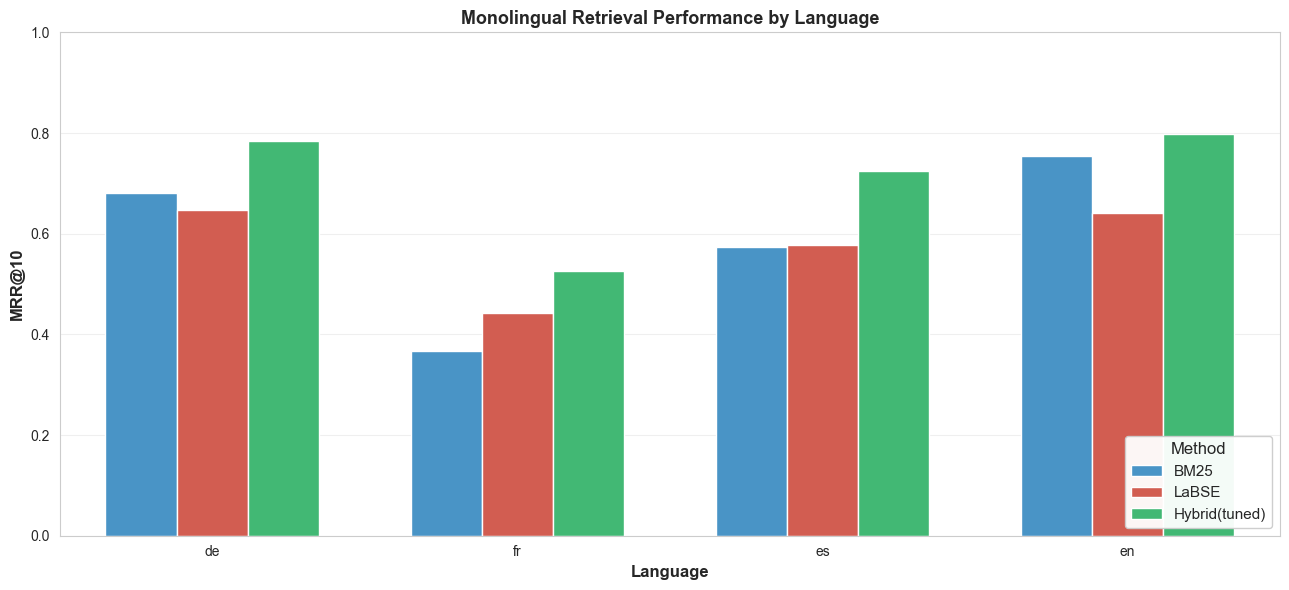

In [20]:
# Plot monolingual MRR@10 by language and method
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(13, 6))

df_mono = df_results_hybrid[
    (df_results_hybrid["split"] == "monolingual") &
    (df_results_hybrid["method"].isin(["BM25", "LaBSE", "Hybrid(tuned)"]))
]

sns.barplot(
    data=df_mono,
    x="language",
    y="MRR@10",
    hue="method",
    hue_order=["BM25", "LaBSE", "Hybrid(tuned)"],
    palette=["#3498db", "#e74c3c", "#2ecc71"],
    width=0.7,
    errorbar=None,
    ax=ax
)

ax.set_xlabel("Language", fontsize=12, fontweight='bold')
ax.set_ylabel("MRR@10", fontsize=12, fontweight='bold')
ax.set_title("Monolingual Retrieval Performance by Language", fontsize=13, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend(title="Method", fontsize=11, title_fontsize=12, loc='lower right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


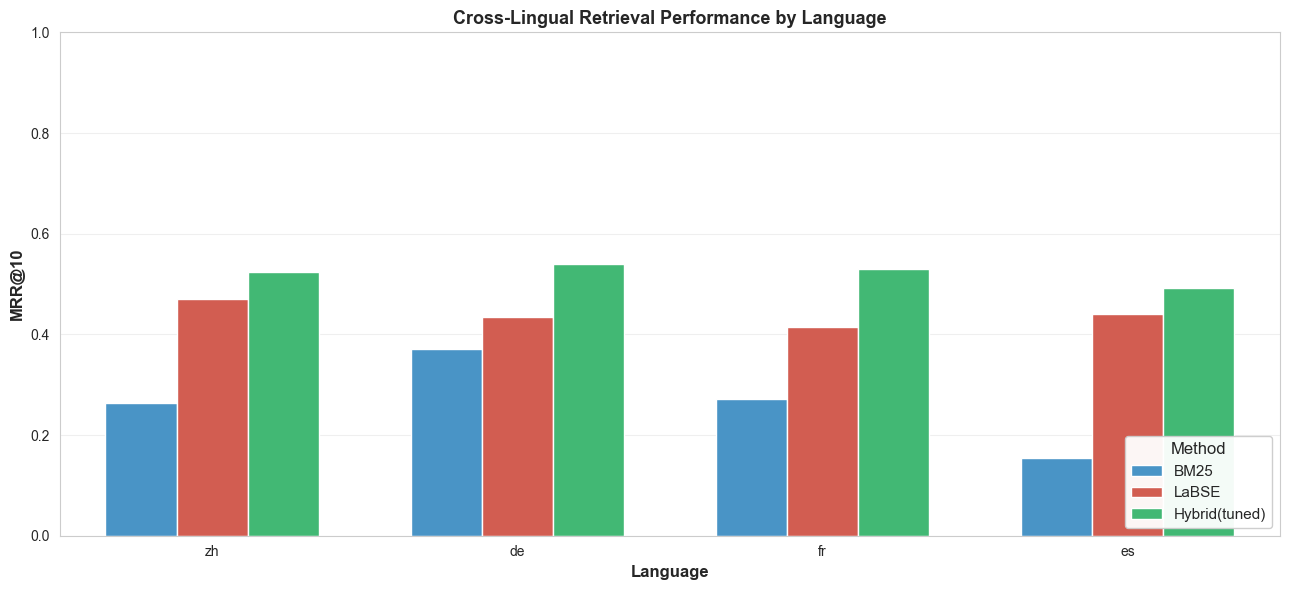

In [21]:
# Plot cross-lingual MRR@10 by language and method
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(13, 6))

df_cross = df_results_hybrid[
    (df_results_hybrid["split"] == "cross_lingual") &
    (df_results_hybrid["method"].isin(["BM25", "LaBSE", "Hybrid(tuned)"]))
]

sns.barplot(
    data=df_cross,
    x="language",
    y="MRR@10",
    hue="method",
    hue_order=["BM25", "LaBSE", "Hybrid(tuned)"],
    palette=["#3498db", "#e74c3c", "#2ecc71"],
    width=0.7,
    errorbar=None,
    ax=ax
)

ax.set_xlabel("Language", fontsize=12, fontweight='bold')
ax.set_ylabel("MRR@10", fontsize=12, fontweight='bold')
ax.set_title("Cross-Lingual Retrieval Performance by Language", fontsize=13, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend(title="Method", fontsize=11, title_fontsize=12, loc='lower right', framealpha=0.95)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Neural Reranking of Hybrid Top‑K Candidates

We add a second stage to improve ranking quality: a multilingual **cross‑encoder** reranks a small candidate set produced by the hybrid retriever.

**Stage 1 — Candidate generation:**
A tuned hybrid model retrieves a shortlist (e.g., top‑100) for each query. This keeps the search efficient while ensuring the relevant document is likely present.

**Stage 2 — Cross‑encoder reranking:**
A multilingual cross‑encoder (`amberoad/bert-multilingual-passage-reranking-msmarco`) scores each (query, document) pair jointly, capturing deeper interactions than bi‑encoder embeddings.

**Why this helps:**
- Higher ranking precision (MRR@10 tends to improve)
- Computationally feasible: expensive scoring is applied only to a small candidate set
- Robust for cross‑lingual mismatch

The code below includes caching, optional sanity checks, and runtime limits so reranking is reproducible and practical on CPU hardware.

In [22]:
# Load multilingual cross-encoder reranker and set CPU thread limits
from sentence_transformers import CrossEncoder

# Limits the number of threads for PyTorch to avoid CPU overload
try:
    import torch
    torch.set_num_threads(min(4, os.cpu_count() or 1))
except Exception:
    pass

# Multilingual reranker model
reranker = CrossEncoder(
    "amberoad/bert-multilingual-passage-reranking-msmarco",
    device="cpu",
    max_length=256  
 )

In [23]:
# Utility: truncate documents before reranking to reduce compute
def truncate_text(text, max_chars=400):
    """
    Truncate text to max_chars, cutting at last space before limit.
    Benefits: 
    - preserves whole words
    - avoids cutting in the middle of a word
    - avoids very short truncations if no space found
    """
    if not text:
        return ""
    t = text.strip()
    if len(t) <= max_chars:
        return t
    # cut at last space before max_chars
    cut = t[:max_chars]
    last_space = cut.rfind(" ")
    return cut if last_space < 50 else cut[:last_space]

In [24]:
# Rerank candidates with the cross-encoder and return ordered docs/scores
def rerank_topk_crossencoder(
    reranker,
    query_text,
    doc_ids,
    documents,
    batch_size=8,
    show_progress=False
):
    # Select only valid documents with non-empty text
    valid_doc_ids = []
    valid_texts = []

    for d in doc_ids:
        dt = documents.get(d, "")
        if isinstance(dt, str) and dt.strip() != "":
            valid_doc_ids.append(d)
            valid_texts.append((query_text, dt))

    # If no valid documents, return empty
    if not valid_doc_ids:
        return [], []

    # Predict - the model returns LOGITS [non_relevant, relevant]
    logits = reranker.predict(
        valid_texts,
        batch_size=batch_size,
        show_progress_bar=show_progress
    )

    logits = np.asarray(logits, dtype=np.float32)
    
    # Manage different logits to scores
    if logits.ndim == 2 and logits.shape[1] == 2:
        # calculate probabilities from logits (2 classes) using softmax
        exp_logits = np.exp(logits)
        probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
        scores = probs[:, 1] # take the "relevant" class probability
    else:
        # Fallback: if single logit per pair, use it directly
        scores = logits.flatten()
    
    scores = scores.flatten()
    
    # Ensure lengths match using minimum length
    if len(scores) != len(valid_doc_ids):
        min_len = min(len(scores), len(valid_doc_ids))
        scores = scores[:min_len]
        valid_doc_ids = valid_doc_ids[:min_len]

    # if we still have no valid scores/docs, return empty
    if len(scores) == 0 or len(valid_doc_ids) == 0:
        return [], []

    # Order by descending scores, first get highest scores
    order = np.argsort(-scores).tolist()

    # Apply the order to valid_doc_ids
    reranked_doc_ids = [valid_doc_ids[i] for i in order]
    reranked_scores  = [float(scores[i]) for i in order]

    return reranked_doc_ids, reranked_scores

In [25]:
def strip_language_prefix(x):
    """
    'de_1' -> '1'
    'en_english_22626#23' -> 'english_22626#23' (if present)
    If no prefix, returns as-is.
    """
    x = str(x)
    if "_" in x:
        a, b = x.split("_", 1)
        if len(a) in (2, 3):  
            return b
    return x

In [26]:
def evaluate_dictqrels(retrieved, qrels_eval, K=10):
    """
    retrieved: {qid: [doc1, doc2, ...]}  (doc ids CLEAN)
    qrels_eval: {qid: {docid: rel_int}}
    """
    recalls = []
    rr_list = []

    for qid, top_docs in retrieved.items():
        rels = qrels_eval.get(qid, {})
        if not rels:
            recalls.append(0.0)
            rr_list.append(0.0)
            continue

        rel_set = {d for d, r in rels.items() if r > 0}

        # Recall@K
        hit = any(d in rel_set for d in top_docs[:K])
        recalls.append(1.0 if hit else 0.0)

        # MRR@K
        rr = 0.0
        for rank, d in enumerate(top_docs[:K], start=1):
            if d in rel_set:
                rr = 1.0 / rank
                break
        rr_list.append(rr)

    return float(np.mean(recalls)), float(np.mean(rr_list))


In [27]:
def normalize_qrels_single_id(qrels):
    """
    From: { 'de_1': 'de_1', ... }
    To: { 'de_1': {'1': 1} }  (doc ids CLEAN)
    Keep qid keys ORIGINAL (with prefix), because evaluate() expects them.
    """
    qrels_eval = {}
    for qid, rel_doc in qrels.items():
        qid_original = str(qid)
        rel_doc_clean = strip_language_prefix(rel_doc)
        qrels_eval[qid_original] = {rel_doc_clean: 1}
    return qrels_eval

In [28]:
# Sanity checks to catch missing queries/docs before reranking
def sanity_check(
    queries_map,
    queries_map_clean,
    docs_map_clean,
    qrels,
    pack,
    alpha,
    K_RERANK=50,
    CANDIDATE_N=200
):
    print("\n==================== SANITY CHECK ====================")

    missing_queries = []
    missing_rel_docs = []
    hybrid_docs_missing = []

    for qid_original, rel_doc_original in qrels.items():
        qid_clean = strip_language_prefix(qid_original)
        rel_doc_clean = strip_language_prefix(rel_doc_original)

        # ---------------------------------------------------
        # 1. Check: query text exists
        # ---------------------------------------------------
        qtext = queries_map.get(qid_original) or queries_map_clean.get(qid_clean)
        if not qtext:
            missing_queries.append((qid_original, qid_clean))
        
        # ---------------------------------------------------
        # 2. Check: relevant doc exists in docs_map_clean
        # ---------------------------------------------------
        if rel_doc_clean not in docs_map_clean:
            missing_rel_docs.append((qid_original, rel_doc_clean))

        # ---------------------------------------------------
        # 3. Check: docs returned by HYBRID exist in docs_map_clean
        # ---------------------------------------------------
        top_docs = hybrid_topk_for_query(
            qid=qid_original,
            alpha=alpha,
            pack=pack,
            K=K_RERANK,
            candN=CANDIDATE_N
        )
        
        top_docs_clean = [strip_language_prefix(d) for d in top_docs]

        for d in top_docs_clean:
            if d not in docs_map_clean:
                hybrid_docs_missing.append((qid_original, d))

    # ---------------------------------------------------
    # Print results
    # ---------------------------------------------------
    print("\n--- Missing queries (no text found) ---")
    if missing_queries:
        for q in missing_queries[:10]:
            print(" ", q)
        print(f"TOTAL missing queries: {len(missing_queries)}")
    else:
        print("OK ✓")

    print("\n--- Relevant documents missing in docs_map_clean ---")
    if missing_rel_docs:
        for q in missing_rel_docs[:10]:
            print(" ", q)
        print(f"TOTAL missing relevant docs: {len(missing_rel_docs)}")
    else:
        print("OK ✓")

    print("\n--- Docs returned by hybrid but NOT in docs_map_clean ---")
    if hybrid_docs_missing:
        for q in hybrid_docs_missing[:10]:
            print(" ", q)
        print(f"TOTAL hybrid docs missing: {len(hybrid_docs_missing)}")
    else:
        print("OK ✓")

    print("\n==================== END CHECK ====================\n")

    return {
        "missing_queries": missing_queries,
        "missing_rel_docs": missing_rel_docs,
        "hybrid_docs_missing": hybrid_docs_missing
    }

**Reranking pipeline overview:**

1. **Hybrid Retrieval (BM25 + Dense)** → top‑$K_{\text{rerank}}$ candidates
2. **Cross‑Encoder Reranking** → refined ordering
3. **Final Top‑$K$** → evaluation with Recall@10 and MRR@10

In [29]:
# Reranking pipeline with caching, optional sanity checks, and runtime controls
K_RERANK = 100
K_FINAL  = 10

METHOD_NAME = "Hybrid(tuned)+Rerank(amberoad-mBERT)"
RERANK_MODEL = "amberoad/bert-multilingual-passage-reranking-msmarco"
RERANK_DEVICE = "cpu"
RERANK_MAX_LEN = 256       # set in CrossEncoder
DOC_TRUNC_CHARS = 400      # truncate documents to this length before reranking
RERANK_BATCH = 8

# Runtime controls
LIMIT_QUERIES = 200        # 0 = all queries
RERANK_VERBOSE = False
RERANK_PRINT_EVERY = 10
RERANK_TIMING_EVERY = 50
DO_SANITY_CHECK = False

# Path of the shared, versionable file (to be pushed)
FROZEN_DIR = "results/rerank"
FROZEN_PATH = os.path.join(FROZEN_DIR, "df_results_rerank_frozen.csv")
os.makedirs(FROZEN_DIR, exist_ok=True)

FORCE_RERANK = False  # set True only if you want to recompute

if (not FORCE_RERANK) and os.path.exists(FROZEN_PATH) and os.path.getsize(FROZEN_PATH) > 0:
    df_results_rerank = pd.read_csv(FROZEN_PATH)
    print(f"Loaded frozen rerank results: {FROZEN_PATH}")
else:
    print("Frozen rerank results not found (or FORCE_RERANK=True). Running reranking...")

    alpha_map = {
        (r["split"], r["language"]): float(r["alpha"])
        for _, r in df_results_hybrid[df_results_hybrid["method"]=="Hybrid(tuned)"].iterrows()
    }

    rerank_results = []

    for split in CORPUS_SPLITS:
        for lang_code in SELECTED_LANGUAGES:
            key = (split, lang_code)
            if key not in SCORE_CACHE:
                continue

            pack = SCORE_CACHE[key]
            needed = ["qrels", "bm25_topk_docs", "bm25_topk_scores", "dense_topk_docs", "dense_topk_scores"]
            if any(k not in pack for k in needed):
                continue

            alpha = alpha_map.get((split, lang_code), 0.3)
            qrels = pack["qrels"]
            query_ids = list(qrels.keys())
            if LIMIT_QUERIES and LIMIT_QUERIES > 0:
                query_ids = query_ids[:LIMIT_QUERIES]

            lang_path = os.path.join(BASE_DATA_DIR, split, lang_code, "train.jsonl")

            # 1. Build set of needed document IDs
            needed_ids = set()

            for qid in query_ids:
                qid = str(qid)
                rel_doc = strip_language_prefix(qrels[qid])
                needed_ids.add(rel_doc)

                # Top-K hybrid: ID with prefix -> clean
                top_docs = hybrid_topk_for_query(
                    qid=qid,
                    alpha=alpha,
                    pack=pack,
                    K=K_RERANK,
                    candN=CANDIDATE_N
                )

                clean = [strip_language_prefix(d) for d in top_docs]
                needed_ids.update(clean)

            if RERANK_VERBOSE:
                print(f"Needed documents: {len(needed_ids)}")

            # Load the exact documents from JSONL used for BM25/Dense
            data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

            docs_map = {}
            queries_map = {}

            # Build maps with prefixed IDs (only needed docs)
            for item in data:
                raw_id = str(item["_id"])
                if raw_id not in needed_ids:
                    continue
                doc_id = f"{lang_code}_{raw_id}"
                queries_map[doc_id] = item.get("query", "")
                docs_map[doc_id] = (item.get("title", "") + " " + item.get("text", "")).strip()
            
            # Clean docs_map (without prefixes - clean IDs)
            docs_map_clean = {
                strip_language_prefix(k): truncate_text(v, max_chars=DOC_TRUNC_CHARS)
                for k, v in docs_map.items()
            }
            
            # Sanity check: ensure relevant doc is in docs_map_clean
            if RERANK_VERBOSE and query_ids:
                allowed = set(docs_map_clean.keys())
                example_qid = query_ids[0]
                rel_clean = strip_language_prefix(qrels[example_qid])
                print("Check overlap:", rel_clean in allowed)
            
            # Clean queries map
            queries_map_clean = {
                strip_language_prefix(k): v
                for k, v in queries_map.items()
            }

            print(f"\n{'='*70}")
            print(f"RERANKING {split}/{lang_code} | alpha={alpha:.2f}")
            print(f"queries loaded: {len(queries_map)} | docs loaded: {len(docs_map)}")
            print(f"{'='*70}")

            # Prepare qrels for evaluation
            qrels_eval = normalize_qrels_single_id(qrels)

            # Optional sanity check
            if DO_SANITY_CHECK:
                _ = sanity_check(
                    queries_map=queries_map,
                    queries_map_clean=queries_map_clean,
                    docs_map_clean=docs_map_clean,
                    qrels=qrels,
                    pack=pack,
                    alpha=alpha,
                    K_RERANK=K_RERANK,
                    CANDIDATE_N=CANDIDATE_N
                )

            reranked_runs = {}
            t0_all = time.time()

            # Rerank each query
            for i, qid_original in enumerate(query_ids):
                qid_original = str(qid_original)
                qid_clean = strip_language_prefix(qid_original)

                qtext = queries_map.get(qid_original) or queries_map_clean.get(qid_clean)
                if not qtext:
                    reranked_runs[qid_original] = []
                    continue

                # Stage 1: HYBRID to get candidates
                top_docs = hybrid_topk_for_query(
                    qid=qid_original,
                    alpha=alpha,
                    pack=pack,
                    K=K_RERANK,
                    candN=CANDIDATE_N
                )

                if not top_docs:
                    reranked_runs[qid_original] = []
                    continue

                # Clean IDs to match docs_map format (WITHOUT prefix)
                top_docs_clean = [strip_language_prefix(d) for d in top_docs]
                valid_docs = [d for d in top_docs_clean if d in docs_map_clean]

                if RERANK_VERBOSE or (i % RERANK_PRINT_EVERY == 0):
                    print(f"Query {qid_original}: {len(valid_docs)} documenti validi per rerank")
                if RERANK_VERBOSE and len(valid_docs) > 0:
                    print(f"  Primo doc: {valid_docs[0]}, testo: {len(docs_map_clean.get(valid_docs[0], ''))} chars")

                if not valid_docs:
                    # Fallback su BM25: use only BM25 candidates that are valid
                    bm25_docs = pack["bm25_topk_docs"].get(qid_original, [])
                    bm25_docs_clean = [strip_language_prefix(d) for d in bm25_docs]
                    valid_docs = [d for d in bm25_docs_clean if d in docs_map_clean]

                if not valid_docs:
                    # if still no valid docs, skip
                    reranked_runs[qid_original] = []
                    continue

                # Stage 2: Rerank (CPU-friendly, small batches)
                rr_docs, rr_scores = rerank_topk_crossencoder(
                    reranker=reranker,
                    query_text=qtext,
                    doc_ids=valid_docs,
                    documents=docs_map_clean,
                    batch_size=RERANK_BATCH,
                    show_progress=False
                )

                # If no reranked docs, skip
                if not rr_docs:
                    reranked_runs[qid_original] = []
                    continue
                # Keep only top-K_FINAL
                reranked_runs[qid_original] = rr_docs[:K_FINAL]

                if RERANK_VERBOSE:
                    if rr_scores:
                        print(f"  Score range: [{min(rr_scores):.4f}, {max(rr_scores):.4f}]")
                        print(f"  Top-3 scores: {rr_scores[:3]}")
                elif (i % RERANK_PRINT_EVERY == 0) and rr_scores:
                    print(f"Query {qid_original}: top score = {rr_scores[0]:.4f}")

                # Log every N queries for execution time
                if (i + 1) % RERANK_TIMING_EVERY == 0:
                    elapsed = time.time() - t0_all
                    print(f"[{i+1}/{len(query_ids)}] elapsed: {elapsed/60:.1f} min")
                    print("-" * 50)

            # Evaluate
            recall_r, mrr_r = evaluate_dictqrels(
                reranked_runs, qrels_eval, K=K_FINAL
            )

            print(f"\n>>> RESULT {split}/{lang_code}")
            print(f"Recall@10 = {recall_r:.4f}")
            print(f"MRR@10    = {mrr_r:.4f}")

            # Store results
            rerank_results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": float(recall_r),
                "MRR@10": float(mrr_r),
                "method": METHOD_NAME,
                "alpha": float(alpha),
                "candN": int(CANDIDATE_N),
                "rerankK": int(K_RERANK),

                # metadata useful for reproducibility
                "rerank_model": RERANK_MODEL,
                "device": RERANK_DEVICE,
                "max_length": int(RERANK_MAX_LEN),
                "doc_trunc_chars": int(DOC_TRUNC_CHARS),
                "batch_size": int(RERANK_BATCH),
            })

            gc.collect()

            df_results_rerank = pd.DataFrame(rerank_results)
            df_results_rerank


Loaded frozen rerank results: results/rerank/df_results_rerank_frozen.csv


In [30]:
# Save rerank results to a frozen CSV (reproducible artifact)

FROZEN_DIR = "results/rerank"
FROZEN_PATH = os.path.join(FROZEN_DIR, "df_results_rerank_frozen.csv")
os.makedirs(FROZEN_DIR, exist_ok=True)

if "df_results_rerank" not in globals() or df_results_rerank is None or df_results_rerank.empty:
    raise RuntimeError("df_results_rerank not available or empty. Run the rerank cell first.")

df_results_rerank.to_csv(FROZEN_PATH, index=False)
print(f" Saved frozen rerank results to: {FROZEN_PATH}")

 Saved frozen rerank results to: results/rerank/df_results_rerank_frozen.csv


In [31]:
# Display a compact rerank results table
CSV_PATH = "results/rerank/df_results_rerank_frozen.csv"  

df = pd.read_csv(CSV_PATH)
cols_preferred = [
    "split", "language", "Recall@10", "MRR@10", "alpha", "candN", "rerankK", "device", "max_length", "doc_trunc_chars", "batch_size", "method"
 ]
cols = [c for c in cols_preferred if c in df.columns]
df_view = df[cols].copy() if cols else df.copy()

sort_cols = [c for c in ["split", "language"] if c in df_view.columns]
if "MRR@10" in df_view.columns:
    df_view = df_view.sort_values(by=sort_cols + ["MRR@10"], ascending=[True]*len(sort_cols) + [False])
else:
    df_view = df_view.sort_values(by=sort_cols) if sort_cols else df_view

display(df_view)




,split,language,Recall@10,MRR@10,alpha,candN,rerankK,device,max_length,doc_trunc_chars,batch_size,method
0,cross_lingual,de,0.815,0.743125,0.2,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
2,cross_lingual,es,0.835,0.769048,0.2,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
1,cross_lingual,fr,0.755,0.715889,0.2,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
3,cross_lingual,zh,0.620,0.546651,0.3,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
4,monolingual,de,0.935,0.921875,0.3,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
7,monolingual,en,0.950,0.940000,0.6,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
6,monolingual,es,0.965,0.937131,0.3,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)
5,monolingual,fr,0.905,0.875000,0.2,500,100,cpu,256,400,8,Hybrid(tuned)+Rerank(amberoad-mBERT)


In [32]:
# Summarize rerank results by split (monolingual/cross-lingual)
import pandas as pd
from IPython.display import display

CSV_PATH = "results/rerank/df_results_rerank_frozen.csv"
df = pd.read_csv(CSV_PATH)

rerank_method = "Hybrid(tuned)+Rerank(amberoad-mBERT)"
if "method" in df.columns and rerank_method in df["method"].unique():
    df = df[df["method"] == rerank_method].copy()

# --- 1) Average per split (cross_lingual vs monolingual) ---
avg_by_split = (
    df.groupby("split", as_index=False)
      .agg(
          Recall_mean=("Recall@10", "mean"),
          MRR_mean=("MRR@10", "mean"),
      )
      .sort_values("split")
)

# --- 2) Combined (cross + mono insieme) ---
avg_combined = pd.DataFrame([{
    "split": "combined",
    "Recall_mean": df["Recall@10"].mean(),
    "MRR_mean": df["MRR@10"].mean(),
}])

avg_final = pd.concat([avg_by_split, avg_combined], ignore_index=True)

# Pretty formatting
print("====== Reranking Results Summary (Average Recall@10 and MRR@10): ======")
display(
    avg_final.style.format({"Recall_mean": "{:.4f}", "MRR_mean": "{:.4f}"})
)

====== Reranking Results Summary (Average Recall@10 and MRR@10): ======


,split,Recall_mean,MRR_mean
0,cross_lingual,0.7562,0.6937
1,monolingual,0.9387,0.9185
2,combined,0.8475,0.8061


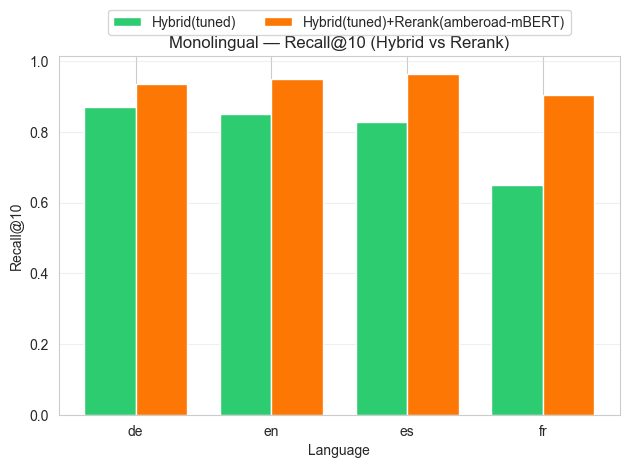

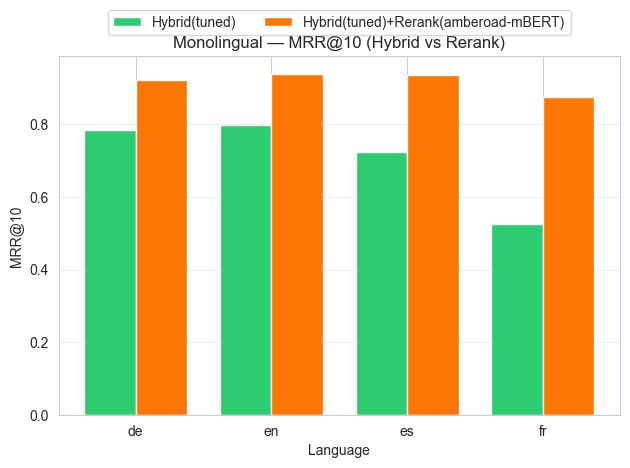

In [33]:
# Compare Hybrid vs Rerank for monolingual languages
df_rerank = pd.read_csv("results/rerank/df_results_rerank_frozen.csv")

hybrid_method_name = "Hybrid(tuned)"
rerank_method_name = "Hybrid(tuned)+Rerank(amberoad-mBERT)"

df_h_mono = df_results_hybrid[
    (df_results_hybrid["split"] == "monolingual") &
    (df_results_hybrid["method"] == hybrid_method_name)
].copy()

df_r_mono = df_rerank[
    (df_rerank["split"] == "monolingual") &
    (df_rerank["method"] == rerank_method_name)
].copy()

keep_cols = ["language", "MRR@10", "Recall@10", "method"]
df_plot = pd.concat([df_h_mono[keep_cols], df_r_mono[keep_cols]], ignore_index=True)


def plot_grouped_bars(df, metric="MRR@10", title=None):
    pv = df.pivot_table(index="language", columns="method", values=metric, aggfunc="mean")

    cols_order = [c for c in [hybrid_method_name, rerank_method_name] if c in pv.columns]
    pv = pv[cols_order].sort_index()

    languages = pv.index.tolist()
    x = np.arange(len(languages))
    width = 0.38

    fig, ax = plt.subplots()
    if hybrid_method_name in pv.columns:
        ax.bar(x - width/2, pv[hybrid_method_name].values, width, label=hybrid_method_name, color='#2ecc71')
    if rerank_method_name in pv.columns:
        ax.bar(x + width/2, pv[rerank_method_name].values, width, label=rerank_method_name, color="#fc7703")

    ax.set_xticks(x)
    ax.set_xticklabels(languages, rotation=0)
    ax.set_xlabel("Language")
    ax.set_ylabel(metric)
    ax.set_title(title or f"Monolingual — {metric}: Hybrid vs Rerank")
    ax.grid(axis="y", alpha=0.3)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)
    plt.tight_layout()
    plt.show()

plot_grouped_bars(df_plot, metric="Recall@10", title="Monolingual — Recall@10 (Hybrid vs Rerank)")
plot_grouped_bars(df_plot, metric="MRR@10", title="Monolingual — MRR@10 (Hybrid vs Rerank)")



In [34]:
# Auto-generate results narrative from frozen artifacts
def _fmt(x, nd=3):
    try:
        return f"{float(x):.{nd}f}"
    except Exception:
        return "n/a"

def _pct(x, nd=1):
    try:
        return f"{float(x)*100:.{nd}f}%"
    except Exception:
        return "n/a"

# Load sources if available
dfs = []
if "df_results_frozen" in globals() and isinstance(df_results_frozen, pd.DataFrame):
    dfs.append(df_results_frozen.copy())
if "df_results_hybrid" in globals() and isinstance(df_results_hybrid, pd.DataFrame):
    dfs.append(df_results_hybrid.copy())

rerank_path = "results/rerank/df_results_rerank_frozen.csv"
df_rerank_auto = None
if os.path.exists(rerank_path):
    df_rerank_auto = pd.read_csv(rerank_path)
    dfs.append(df_rerank_auto.copy())

if len(dfs) == 0:
    raise RuntimeError("No results found. Run retrieval/reranking cells or load frozen results first.")

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=["method", "Recall@10", "MRR@10"], how="any")

# Overall averages by method
method_avg = (
    df_all.groupby("method")[["Recall@10", "MRR@10"]]
    .mean()
    .sort_values("MRR@10", ascending=False)
)

# Head-to-head BM25 vs LaBSE (same split/lang)
bm25_vs_dense = None
if "BM25" in df_all["method"].values and "LaBSE" in df_all["method"].values:
    pivot_mrr = df_all.pivot_table(
        index=["split", "language"],
        columns="method",
        values="MRR@10",
        aggfunc="mean",
    )
    if "BM25" in pivot_mrr.columns and "LaBSE" in pivot_mrr.columns:
        better = (pivot_mrr["LaBSE"] > pivot_mrr["BM25"]).sum()
        worse = (pivot_mrr["LaBSE"] < pivot_mrr["BM25"]).sum()
        ties = (pivot_mrr["LaBSE"] == pivot_mrr["BM25"]).sum()
        total = int(better + worse + ties)
        bm25_vs_dense = {"better": int(better), "worse": int(worse), "ties": int(ties), "total": total}

# Best method per split/language (by MRR)
best_by_lang = (
    df_all.sort_values("MRR@10", ascending=False)
    .groupby(["split", "language"])
    .first()
    .reset_index()
)

# Build narrative
lines = []
lines.append("# Summary of Results (auto-generated)")
lines.append("")
lines.append("## Overall Performance (average across evaluated languages)")
for method, row in method_avg.iterrows():
    lines.append(f"- **{method}** — Recall@10: **{_pct(row['Recall@10'])}**, MRR@10: **{_fmt(row['MRR@10'])}**")

if bm25_vs_dense and bm25_vs_dense["total"] > 0:
    lines.append("")
    lines.append("### Head-to-Head: LaBSE vs BM25 (by split/language)")
    lines.append(
        f"- LaBSE wins: **{bm25_vs_dense['better']}** | BM25 wins: **{bm25_vs_dense['worse']}** | Ties: **{bm25_vs_dense['ties']}** (Total: {bm25_vs_dense['total']})"
    )

lines.append("")
lines.append("### Best Method per Language (by MRR@10)")
for _, r in best_by_lang.iterrows():
    lines.append(f"- **{r['split']}/{r['language']}**: {r['method']} (MRR@10={_fmt(r['MRR@10'])}, Recall@10={_pct(r['Recall@10'])})")

display(Markdown("\n".join(lines)))

# Summary of Results (auto-generated)

## Overall Performance (average across evaluated languages)
- **Hybrid(tuned)+Rerank(amberoad-mBERT)** — Recall@10: **84.8%**, MRR@10: **0.806**
- **Hybrid(tuned)** — Recall@10: **74.3%**, MRR@10: **0.615**
- **LaBSE** — Recall@10: **65.2%**, MRR@10: **0.509**
- **BM25** — Recall@10: **53.6%**, MRR@10: **0.430**

### Head-to-Head: LaBSE vs BM25 (by split/language)
- LaBSE wins: **6** | BM25 wins: **2** | Ties: **0** (Total: 8)

### Best Method per Language (by MRR@10)
- **cross_lingual/de**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.743, Recall@10=81.5%)
- **cross_lingual/es**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.769, Recall@10=83.5%)
- **cross_lingual/fr**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.716, Recall@10=75.5%)
- **cross_lingual/zh**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.547, Recall@10=62.0%)
- **monolingual/de**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.922, Recall@10=93.5%)
- **monolingual/en**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.940, Recall@10=95.0%)
- **monolingual/es**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.937, Recall@10=96.5%)
- **monolingual/fr**: Hybrid(tuned)+Rerank(amberoad-mBERT) (MRR@10=0.875, Recall@10=90.5%)

# Results
The narrative in the previous cell is **auto‑generated** from frozen result artifacts, ensuring the reported numbers match the latest experiments (including changes to `MAX_ITEMS`, `CANDIDATE_N` or reranking settings).

**`MAX_ITEMS = 10,000`.**
The full dataset contains approximately 18.7 million query–document pairs. Dense retrieval and cross‑encoder reranking are computationally expensive and do not scale well on CPU. Limiting each run to 10,000 items enables repeatable experiments and fair comparisons across methods while keeping compute and memory requirements manageable.

**Language selection (de, fr, es, en, zh).**
These languages cover multiple families and scripts and include both monolingual and cross‑lingual scenarios. This selection provides meaningful diversity while keeping the experimental scope tractable.

## Conclusion
The primary driver of the results is the structural mismatch in the cross‑lingual splits: queries are written in non‑English languages while documents are in English. This severely limits lexical overlap, which explains the weaker performance of BM25 in these settings. Dense retrieval models perform better because they rely on semantic similarity rather than shared tokens.

Models such as LaBSE embed multilingual text into a shared representation space, allowing semantically equivalent queries and documents to align despite language differences. Hybrid retrieval further improves robustness by combining lexical precision from BM25 with semantic matching from dense embeddings. Reranking mainly affects MRR@10, as the cross‑encoder refines the ordering of the top‑K candidates even when recall remains similar. Performance varies across languages due to differences in data size, scripts and translation quality, which justifies reporting per‑language results.

The results show that dense retrieval is critical for cross‑lingual IR, hybrid methods are often strongest overall and reranking improves top‑rank quality. 
Language‑specific effects are significant, so per‑language analysis is necessary. 
Overall, the findings support a two‑stage multilingual IR pipeline with strong candidate retrieval followed by reranking for precision.

## Future Work
- **Scale to larger subsets or full splits** to validate stability of the trends at higher data volumes.
- **Evaluate additional languages and scripts** (especially low‑resource ones) to better characterize cross‑lingual robustness.
- **Test stronger dense models or fine‑tuning** on SWIM‑IR to quantify gains over zero‑shot LaBSE.
- **Explore efficient retrieval backends** (e.g., ANN/FAISS) to enable larger‑scale dense retrieval and reranking.